In [1]:
import torch
import torch.nn.functional as f
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torchsummary import summary
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Train data transformation

train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                       ])
                                       

# Test transform

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                      ])

Dataset and creating Train/Test split

In [3]:
train = datasets.MNIST(root='../data', train=True, download=True, transform=train_transforms)

test = datasets.MNIST(root='../data', train=False, download=True, transform=test_transforms)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataloader arguments and train test dataloaders

In [4]:
torch.manual_seed(100)

In [5]:
cuda = torch.cuda.is_available()

if cuda:
  print('\n CUDA is available')
  torch.cuda.manual_seed(100)
else:
  print("\n No GPU")

  


 CUDA is available


In [6]:
WORKERS = 2
BATCH_SIZE = 64

In [7]:
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=WORKERS, pin_memory=True) if cuda\
 else dict(shuffle=True, batch_size=BATCH_SIZE)

In [8]:
# train dataloader 

train_loader = torch.utils.data.DataLoader(dataset=train, **dataloader_args)


# test dataloader

test_loader = torch.utils.data.DataLoader(dataset=test, **dataloader_args)

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

In [10]:

def train(model, device, train_loader, optimizer, epochs=1, scheduler=None, test=False, test_loader=None, reset=None):
    if test and not test_loader:
        raise ValueError("`test`= True but `test_loader` not provided")
    if reset:
      for i in reset:
          if i:
              i = []
          
    model.train()
    for epoch in range(epochs):
      correct = 0
      processed = 0
      train_loss = 0
      print(f"\n\nepoch: {epoch+1}")
      pbar = tqdm(train_loader)
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = f.nll_loss(output, target)
          train_loss += loss.item()
          loss.backward()
          optimizer.step()
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          processed += len(data)
      acc = 100 * correct/processed
      train_losses.append(train_loss)
      train_accuracy.append(acc)
      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
      if scheduler:
          print(f'lr: {scheduler.get_last_lr()[0]}')
          scheduler.step()
      
      train_loss /= len(train_loader.dataset)
      print('\nTrain set:                              Accuracy: {}/{} ({:.6f}%)'.format(correct, len(train_loader.dataset), 100.0 * correct / len(train_loader.dataset)))

      if test:
          model.eval()
          test_loss = 0
          correct = 0
          with torch.no_grad():
              for data, target in test_loader:
                  data, target = data.to(device), target.to(device)
                  output = model(data)
                  test_loss += f.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  correct += pred.eq(target.view_as(pred)).sum().item()

          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          test_accuracy.append(100. * correct / len(test_loader.dataset))

          print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

## CODE 3 - > after BN + DO -> Here I decrease channel numbers and introduce Average Pooling to get a decent accuracy.



In [11]:
class Net2(nn.Module):        
    def __init__(self):
        super(Net2, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12)
        ) # output_size = 24
        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        
        self.convblock3 = nn.Sequential( # mixing channel information here to re-create information into 16 channels
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        ) # output_size = 12

        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        ) # output_size = 10

        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        ) 
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) 


        self.avg_pool = nn.AvgPool2d(kernel_size=6)

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        
        self.dropout = nn.Dropout2d(0.12) 
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.pool1(x) # since it's MNIST and 1x28x28 images, 7x7 makes little sense for such small image dataset to get related features, so starting network itself contains maxpool at 5x5 RF
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        # x = self.convblock7(x)
        # x = self.dropout(x)
        # x = self.convblock8(x)
        # x = self.dropout(x)
        x = self.avg_pool(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return f.log_softmax(x, dim=-1)

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model2 = Net2().to(device)

summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,512
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
        Dropout2d-13           [-1, 14, 10, 10]               0
           Conv2d-14             [-1, 1

In [13]:
optimizer = optim.SGD(model2.parameters(), lr=0.01,momentum=0.9)
train(model2, device, train_loader, optimizer, epochs=15, scheduler=None, test=True, test_loader=test_loader, reset = [train_losses, test_losses, train_accuracy, test_accuracy])

  0%|          | 0/938 [00:00<?, ?it/s]



epoch: 1


100%|██████████| 938/938 [00:14<00:00, 64.67it/s]


Train set:                              Accuracy: 48802/60000 (81.336667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0711, Accuracy: 9803/10000 (98.030000%)



epoch: 2


100%|██████████| 938/938 [00:13<00:00, 68.44it/s]


Train set:                              Accuracy: 58934/60000 (98.223333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9890/10000 (98.900000%)



epoch: 3


100%|██████████| 938/938 [00:13<00:00, 68.97it/s]


Train set:                              Accuracy: 59215/60000 (98.691667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9895/10000 (98.950000%)



epoch: 4


100%|██████████| 938/938 [00:13<00:00, 69.61it/s]


Train set:                              Accuracy: 59350/60000 (98.916667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9899/10000 (98.990000%)



epoch: 5


100%|██████████| 938/938 [00:13<00:00, 69.13it/s]


Train set:                              Accuracy: 59454/60000 (99.090000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9899/10000 (98.990000%)



epoch: 6


100%|██████████| 938/938 [00:13<00:00, 69.29it/s]


Train set:                              Accuracy: 59503/60000 (99.171667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9907/10000 (99.070000%)



epoch: 7


100%|██████████| 938/938 [00:13<00:00, 69.43it/s]


Train set:                              Accuracy: 59573/60000 (99.288333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9903/10000 (99.030000%)



epoch: 8


100%|██████████| 938/938 [00:13<00:00, 70.97it/s]


Train set:                              Accuracy: 59561/60000 (99.268333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9918/10000 (99.180000%)



epoch: 9


100%|██████████| 938/938 [00:13<00:00, 69.54it/s]


Train set:                              Accuracy: 59626/60000 (99.376667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9921/10000 (99.210000%)



epoch: 10


100%|██████████| 938/938 [00:13<00:00, 69.44it/s]


Train set:                              Accuracy: 59633/60000 (99.388333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9922/10000 (99.220000%)



epoch: 11


100%|██████████| 938/938 [00:13<00:00, 69.75it/s]


Train set:                              Accuracy: 59690/60000 (99.483333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9925/10000 (99.250000%)



epoch: 12


100%|██████████| 938/938 [00:13<00:00, 69.30it/s]


Train set:                              Accuracy: 59730/60000 (99.550000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9920/10000 (99.200000%)



epoch: 13


100%|██████████| 938/938 [00:13<00:00, 69.89it/s]


Train set:                              Accuracy: 59777/60000 (99.628333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9922/10000 (99.220000%)



epoch: 14


100%|██████████| 938/938 [00:13<00:00, 69.46it/s]


Train set:                              Accuracy: 59746/60000 (99.576667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9909/10000 (99.090000%)



epoch: 15


100%|██████████| 938/938 [00:13<00:00, 67.63it/s]


Train set:                              Accuracy: 59754/60000 (99.590000%)



Test set: Average loss: 0.0294, Accuracy: 9919/10000 (99.190000%)



Text(0.5, 1.0, 'Test Accuracy')

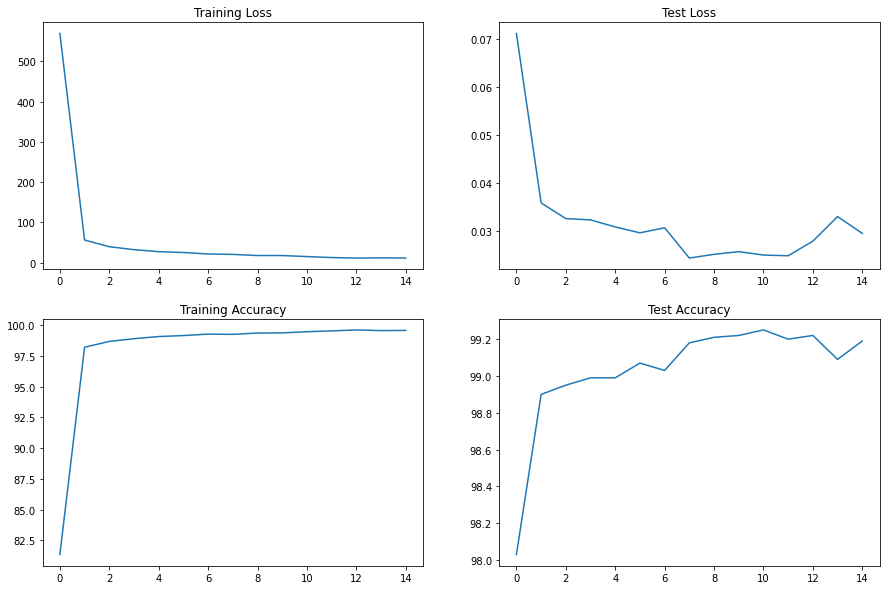

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")

# Analysis

#### After adding Average Pooling while also changing the number of kernels in this code, the last epoch train and test accuracies are: 99.59% and 99.19% respectively

#### The gap is still around 0.40%, despite dropping the parameters the train accuracy hit 99% in 5th epoch and the test accuracy crossed 99% mark in 6th epoch show casing that for MNIST data set we could achive high accuracies on both train and test datasets even with very small number of parameters.

#### I guess making 10 channel output before Average Pooling and using 1x1x10 after Average Pooling helped, *intuition:* prominent 10 channel are pushed forward by backprop before Average pool so 10 dinstinctive outputs can become prominent for prediction.

#### The dropout rate had to be tinkered with to see which value gives decent accuracy improvements.

#### The model is still unable to generalize well on test dataset (even after BN and Dropout). Other approach is to include some form of Image Augmentation to see if the test accuracy could improve further.